## Independent Component Analysis (ICA) with Multiple Sensors

### Authors
* Kevin Chu (kevin@velexi.com)

### Executive Summary
In this Jupyter notebook, we demonstrate the basic ICA algorithm when multiple sensors are used for measurements. The multi-sensor case is common for most situations where ICA is used.

#### Assumptions

* The pressure wave emitted from sources has zero temporal mean.

### Overview of ICA

#### Signal Model

In multi-sensor ICA, the signal recorded by a set of sensors is assumed to be a linear combination of the source signals:

$$
s_i(t) = \sum_{j = 1}^N a_{ij} x_j(t)
$$

where $s_i(t)$ is the mixed signal at by the $i$-th sensor, $x_j(t)$ the $j$-th source, and $a_{ij}$ is the strength of the $j$-th source at the $i$-th sensor. Because the $a_{ij}$ define how the source signals are mixed to obtain the sensor signals, they are called _mixing coefficients_.

The mixing equations can be expressed in matrix form as:

$$
\vec{s}(t) = \mathbf{A} \vec{x}(t)
$$

where $\vec{s} = [s_1, \ldots, s_M]^T$ and $\vec{x} = [x_1, \ldots, x_N]^T$ are the sensor and source signal vectors, respectively, and $\mathbf{A}$ is the _mixing matrix_.

In a noisy environment, the signal model is modified to include a noise term

$$
s_i(t) = \sum_{j = 1}^N a_{ij} x_j(t) + \sigma w_i(t)
$$

where $w_i(t)$ is Gaussian white noise with power $\sigma^2$.

#### ICA Theory

Assuming source signals are statistically independent, independent component analysis (ICA) algorithm performs _blind source separation_. In other words, the algorithm extracts source signals _using only sensor data_. Mathematically, the algorithm estimates $x_j(t)$.

In addition to extracting the source signals, the ICA algorithm estimates the mixing coefficients, $a_{ij}$, of the sensors.

#### ICA Algorithm

Modern implementations of ICA are based on FastICA, an algorithm that uses fast fixed-point iteration to simultaneously solve for the source signals $x_j(t)$ and the mixing coefficients $a_{ij}$.

### References

* A. Hyvarinen and E. Oja. "Independent Component Analysis: algorithms and applications". _Neural Networks_, Vol. 13, pp. 411-430 (2000).

* A. Hyvarinen. "Fast and robust fixed-point algorithms for independent component analysis". _IEEE Transactions on Neural Networks_, Vol. 10, pp. 626-634 (1999).

* A. Tharwat. "Independent Component Analysis: an Introduction". _Applied Computing and Informatics_, Vol. 17, pp. 222-249 (2021).

* "Blind source separation using FastICA". _scikit-learn Documentation_, 16 February 2023, https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html.

* "sklearn.decomposition.FastICA". _scikit-learn Documentation_, 16 February 2023, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA.

### History

#### 2023-02-16

- Initial revision.

### User Parameters

#### Source parameters
* `num_active_sources`: number of source signals to combine for mixed signal
* `noise_level`: standard deviation of Gaussian noise added to mixed signal

#### Sensor parameters
* `num_sensors`: number of sensors used to record signal

#### Sensitivity parameters
* `SNR`: signal to noise ratio

#### Sampling parameters
* `duration`: duration of audio clip
* `sampling_rate`: sampling rate of audio clip

In [1]:
# --- User parameters

# Source parameters
num_active_sources = 5
noise_level = 0.2

# Sensor parameters
num_sensors = num_active_sources + 1

# Sensitivity parameters
SNR = 2

# Sampling parameters
duration = 10
sampling_rate = 44100  # Hz

### Preparations

In [2]:
# --- Imports

# Standard library
import math
from math import pi
import random

# External packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.decomposition import FastICA

### Construct Time Samples

In [3]:
# --- Generate sample times

t_start = 0
t_end = duration
num_steps = math.ceil((t_end - t_start) * sampling_rate)
times, dt = np.linspace(0, t_end, num=num_steps, retstep=True)

In [4]:
# --- Compute plot times

t_plot_end = 6
t_plot_end_idx = len(times[times <= t_plot_end])

In [5]:
# --- Display sampling statistics

num_time_samples = len(times)
print(f"Number of time samples: {num_time_samples}")

Number of time samples: 441000


### Construct Source Signals

In [6]:
# --- Generate source signals

# Initialize DataFrame
source_signals_df = pd.DataFrame()
source_signals_df["t"] = times
source_signals_df.set_index("t", inplace=True)

# sinusoidal waves
frequencies = [4, 5, 6]
num_frequencies = len(frequencies)
sinusoidal_waves = np.zeros([num_steps, num_frequencies])
for i, frequency in enumerate(frequencies):
    phase_shift = 2 * pi * random.random()
    sinusoidal_waves[:, i] = np.sin(2 * pi * frequency * times + phase_shift)
    source_signals_df[f"sin(frequency={frequency}))"] = sinusoidal_waves[:, i]

# sawtooth waves
sawtooth_frequencies = [0.5, 0.25]
num_sawtooth_frequencies = len(sawtooth_frequencies)
sawtooth_waves = np.zeros([num_steps, num_sawtooth_frequencies])
for i, frequency in enumerate(sawtooth_frequencies):
    phase_shift = 2 * pi * random.random()
    sawtooth_waves[:, i] = signal.sawtooth(2 * pi * frequency * times + phase_shift)
    source_signals_df[f"sawtooth(frequency={frequency}))"] = sawtooth_waves[:, i]

# square waves
square_wave_duties = [0.3]
square_waves = np.zeros([num_steps, len(square_wave_duties)])
for i, duty in enumerate(square_wave_duties):
    phase_shift = 2 * pi * random.random()
    square_waves[:, i] = signal.square(2 * pi * times + phase_shift, duty)
    source_signals_df[f"square(duty={duty}))"] = square_waves[:, i]

# Convert DataFrame to NumPy array
source_signals = source_signals_df.to_numpy()

# Compute source indexes
source_indexes = list(range(source_signals.shape[1]))

<Figure size 640x480 with 0 Axes>

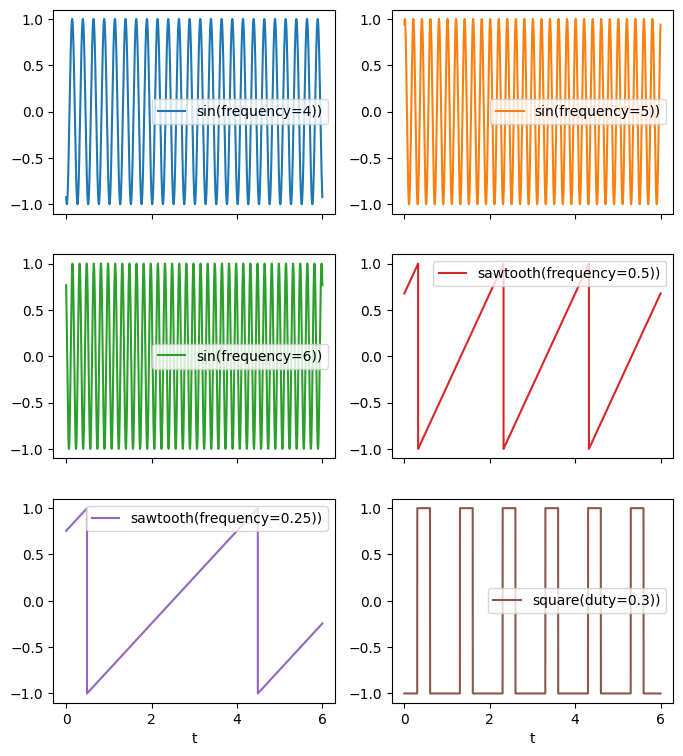

In [7]:
# --- Visually inspect source signals

plt.figure()
num_rows = math.ceil(len(source_indexes)/2)
source_signals_df.iloc[0:t_plot_end_idx].plot(subplots=True, figsize=(8, 3*num_rows), 
                       layout=(num_rows, 2),
                       xlabel="t")

plt.show()
display()  # suppress matplotlib console output

### ICA for Noiseless Sensor Signals

#### Construct Noiseless Sensor Signals

In [8]:
# --- Generate random mixing coefficients

# Select sources to include in mixed signal
active_sources = random.sample(source_indexes, num_active_sources)

# Generate mixing coefficients (bounded away from zero power)
A = (1 - SNR * noise_level) * np.random.random([num_sensors, num_active_sources]) \
  + SNR * noise_level
A_sign = np.sign(2 * np.random.random([num_sensors, num_active_sources]) - 1)
A *= A_sign

In [9]:
# --- Construct sensor signals

# Since, we store $\vec{s}$ and $\vec{x}$ as row vectors in matrices where each row
# represents a time point, we use the transpose of the mixing equation for our
# computations.

sensor_signals = source_signals[:, active_sources] @ A.T

<Figure size 640x480 with 0 Axes>

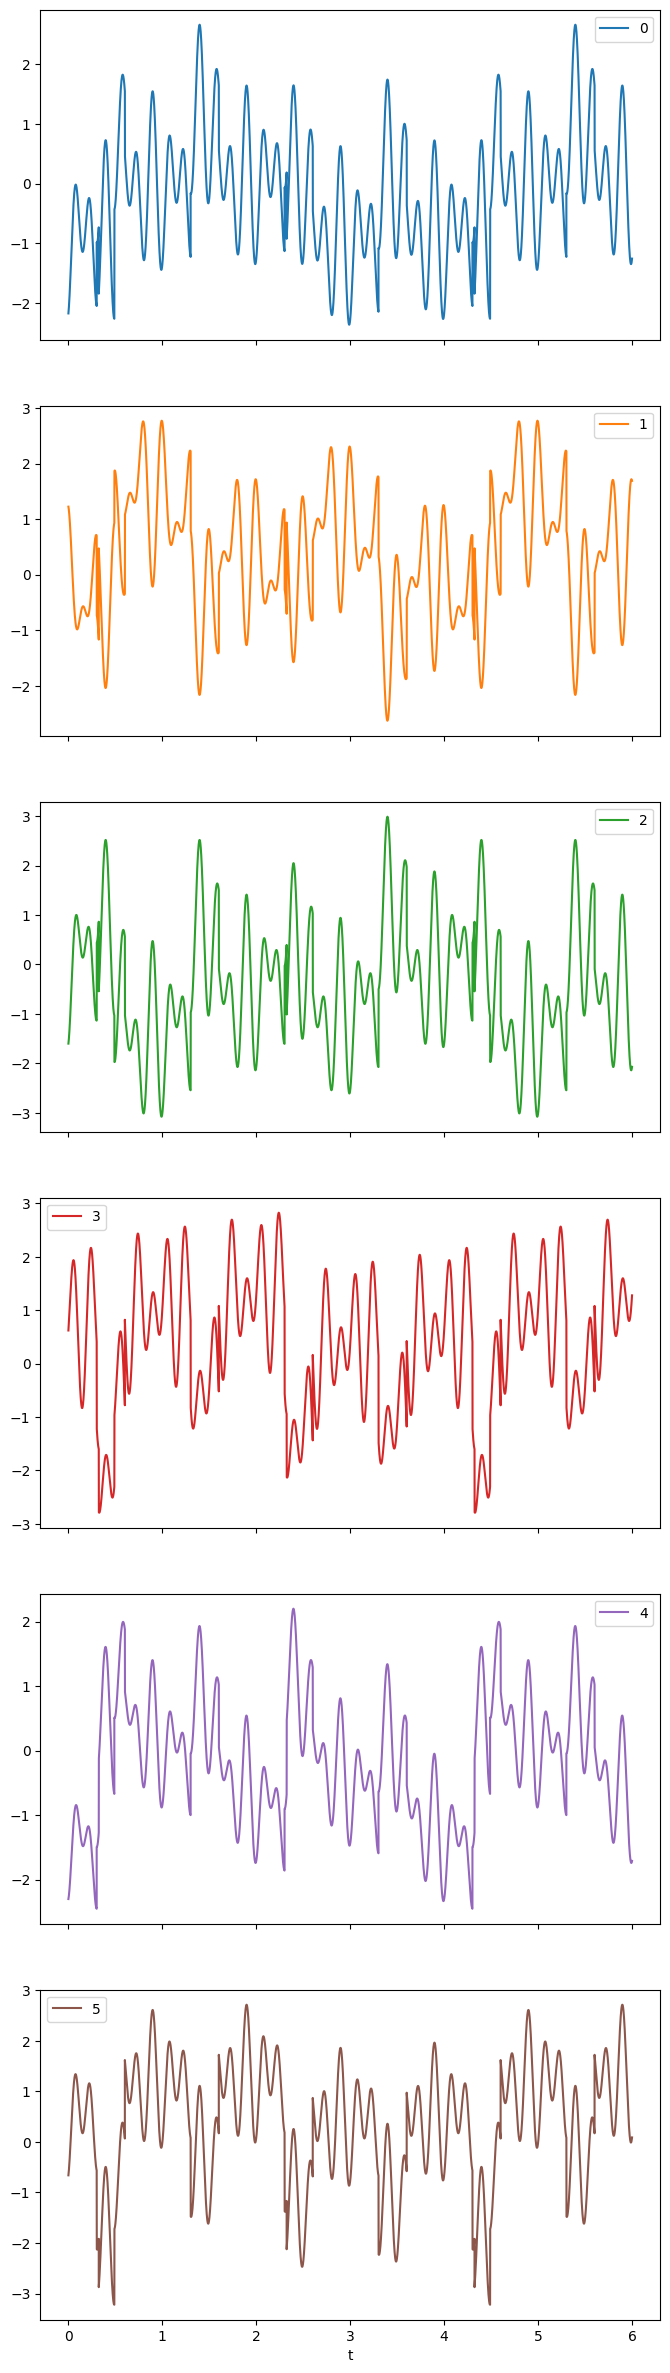

In [10]:
# --- Visually inspect sensor signals

sensor_signals_df = pd.DataFrame(sensor_signals)
sensor_signals_df["t"] = times
sensor_signals_df.set_index("t", inplace=True)

plt.figure()
sensor_signals_df.iloc[0:t_plot_end_idx,:].plot(subplots=True, figsize=(8, 30), layout=(len(source_indexes), 1),
                       xlabel="t"
                       )

display()  # suppress matplotlib console output

#### Perform ICA to Extract Source Signals from Sensor Signals

In [11]:
# --- Perform ICA

ica = FastICA(n_components=num_active_sources, whiten="arbitrary-variance")
ica = FastICA(n_components=num_active_sources, whiten="unit-variance")

# Reconstruct signals
source_signals_ica = ica.fit_transform(sensor_signals)

# Get estimated mixing matrix
A_ica = ica.mixing_  

In [12]:
# --- Validate Results

# ICA produces source signals and a mixing matrix that reproduce the sensor signals
assert np.allclose(sensor_signals, np.dot(source_signals_ica, A_ica.T) + ica.mean_)

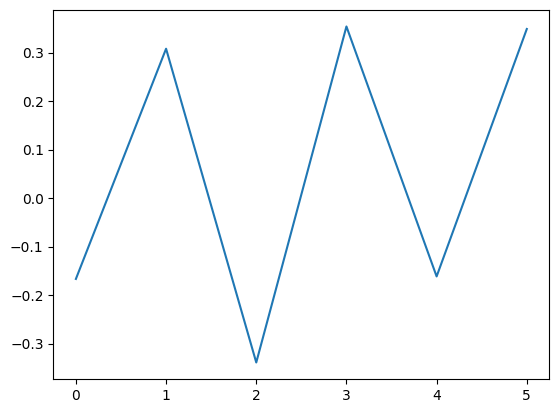

In [13]:
# --- Visually inspect mean

plt.figure()
plt.plot(ica.mean_)

<Figure size 640x480 with 0 Axes>

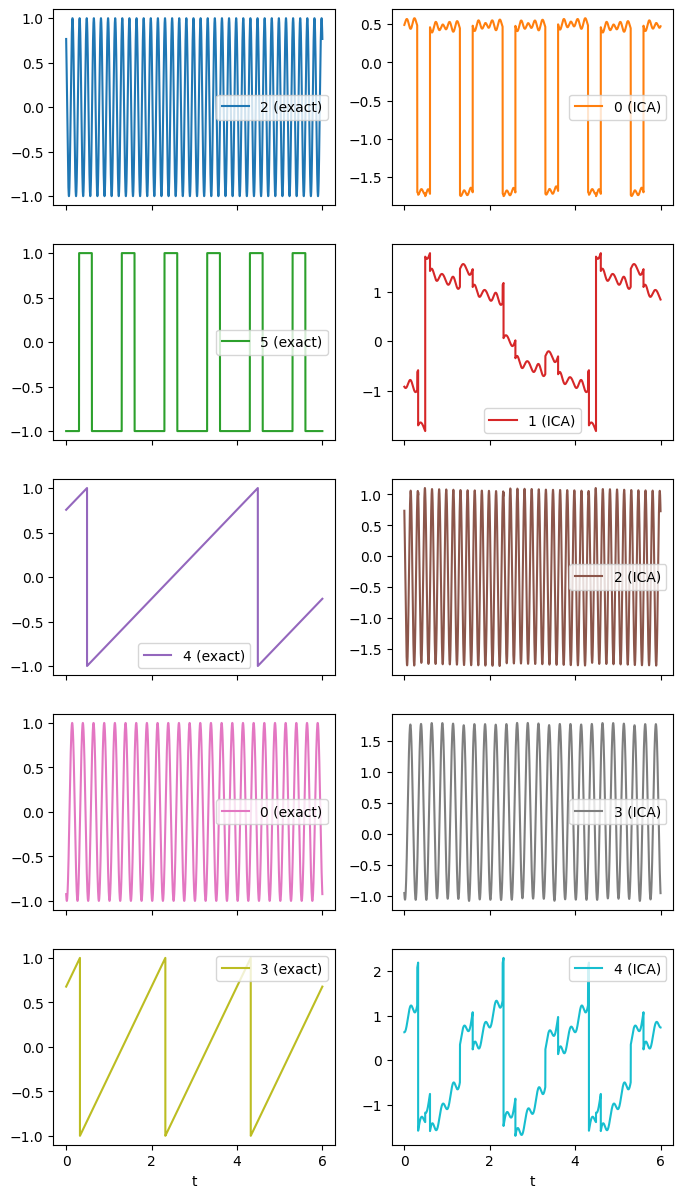

In [14]:
# --- Visually compare extracted to active source signals

source_signals_results_df = pd.DataFrame()
source_signals_results_df["t"] = times
source_signals_results_df.set_index("t", inplace=True)

for i, idx in enumerate(active_sources):
    source_signals_results_df[f"{idx} (exact)"] = source_signals[:, idx]
    source_signals_results_df[f"{i} (ICA)"] = source_signals_ica[:, i] + ica.mean_[i]

plt.figure()
source_signals_results_df.iloc[0:t_plot_end_idx].plot(subplots=True, figsize=(8, 30),
                               layout=(source_signals_results_df.shape[1], 2),
                               xlabel="t"
                               )

display()  # suppress matplotlib console output

### ICA for Noisy Sensor Signals

#### Construct Noisy Sensor Signals

In [15]:
# --- Construct noisy sensor signals

# Since, we store $\vec{s}$ and $\vec{x}$ as row vectors in matrices where each row
# represents a time point, we use the transpose of the mixing equation for our
# computations.

sensor_signals_noisy = \
    sensor_signals + noise_level * np.random.normal(size=sensor_signals.shape)

<Figure size 640x480 with 0 Axes>

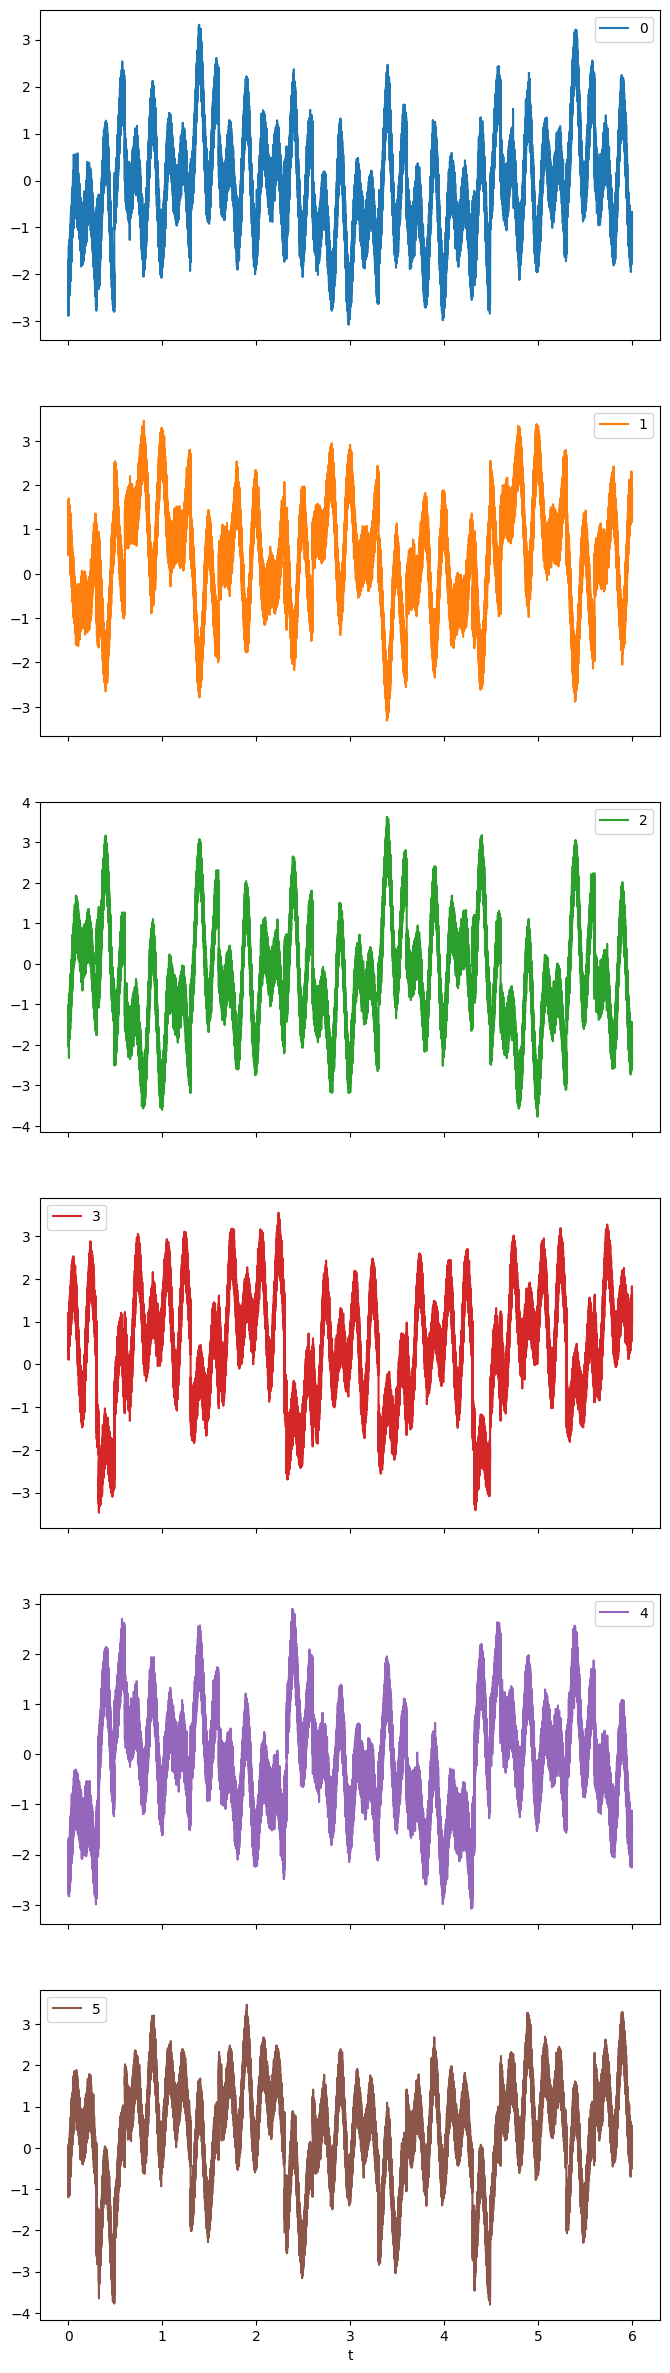

In [16]:
# --- Visually inspect sensor signals

sensor_signals_noisy_df = pd.DataFrame(sensor_signals_noisy)
sensor_signals_noisy_df["t"] = times
sensor_signals_noisy_df.set_index("t", inplace=True)

plt.figure()
sensor_signals_noisy_df.iloc[0:t_plot_end_idx,:].plot(subplots=True, figsize=(8, 30), layout=(len(source_indexes), 1),
                       xlabel="t"
                       )

display()  # suppress matplotlib console output

#### Perform ICA to Extract Source Signals from Sensor Signals

In [17]:
# --- Perform ICA

ica = FastICA(n_components=num_active_sources, whiten="arbitrary-variance")
ica = FastICA(n_components=num_active_sources, whiten="unit-variance")

# Reconstruct signals
source_signals_noisy_ica = ica.fit_transform(sensor_signals_noisy)  # Reconstruct signals

# Get estimated mixing matrix
A_noisy_ica = ica.mixing_  # Get estimated mixing matrix

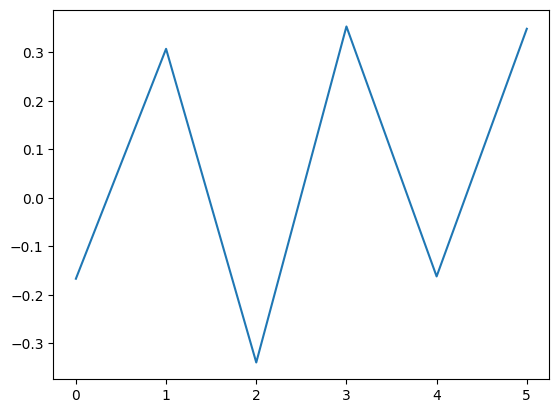

In [18]:
# --- Visually inspect mean

plt.figure()
plt.plot(ica.mean_)

<Figure size 640x480 with 0 Axes>

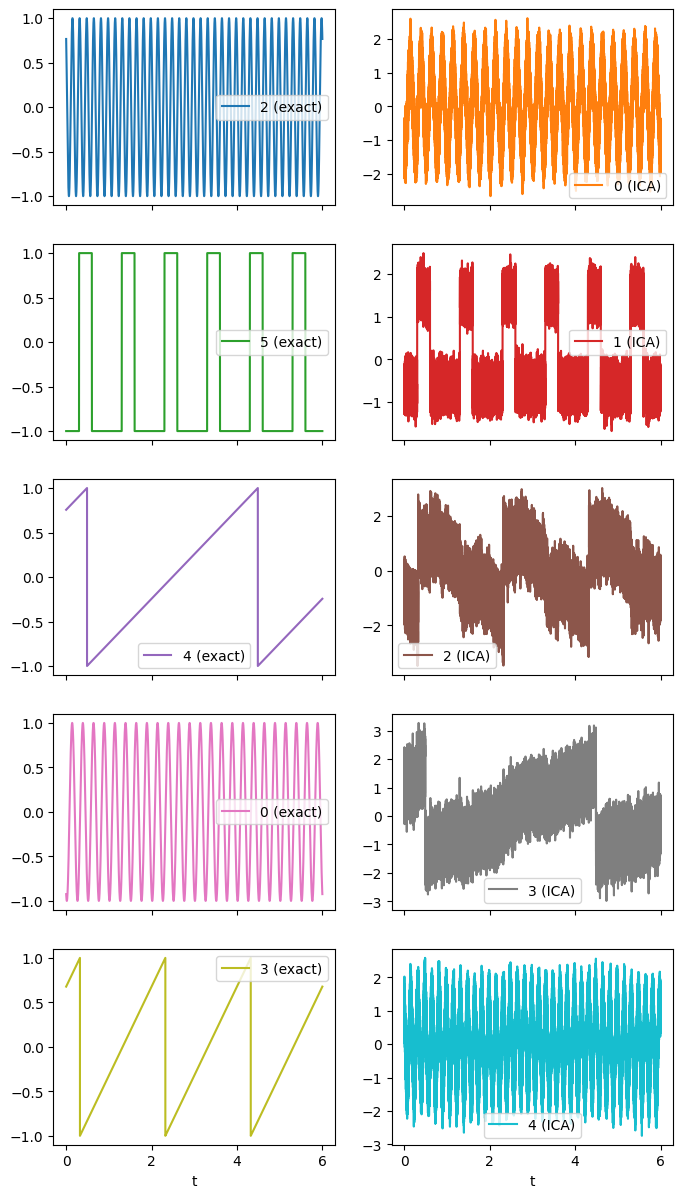

In [19]:
# --- Visually compare extracted to active source signals

source_signals_results_df = pd.DataFrame()
source_signals_results_df["t"] = times
source_signals_results_df.set_index("t", inplace=True)

for i, idx in enumerate(active_sources):
    source_signals_results_df[f"{idx} (exact)"] = source_signals[:, idx]
    source_signals_results_df[f"{i} (ICA)"] = source_signals_noisy_ica[:, i]

plt.figure()
source_signals_results_df.iloc[0:t_plot_end_idx].plot(subplots=True, figsize=(8, 30),
                               layout=(source_signals_results_df.shape[1], 2),
                               xlabel="t"
                               )

display()  # suppress matplotlib console output